# Q2. MachineLearning/DeepLearning Analysis   

>> background : 결측치 처리 완료함(Data_01_imputed_result.csv)
   #
1. Multi-task Learning (Multi-label Classification)   
당뇨 및 고혈압 유병 분류 문제에서 single-label을 고려하는 것이 아닌, 두 종류의 label을 함께 고려하는 multi-task learning (multi-label classification) 분석을 수행하기.
> single-label로 분석할 때와 비교.

2. 생체 나이 추정 모델   
동일 데이터에 대해 나이(AGE 변수)를 예측하는 모델로 태스크를 변경하여 생체 나이 추정 모형을 만들기.
> 이 과정에서 데이터의 구조가 어떻게 변화하는지 설명하고, 나이 예측 모델에 맞는 성능 지표의 결과를 제시하기

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score,hamming_loss

# 데이터 확인
import pandas as pd
data = pd.read_csv("./Data_01_imputed_result.csv")

# print(data.head())  # 데이터 일부 출력
# print(data.info())  # 데이터 정보 출력
# print(data.describe())  # 데이터 통계 정보 출력

In [2]:
# 클래스 불균형 확인
print(data['Target_DM'].value_counts())
print(data['Target_HT'].value_counts())

Target_DM
0.0    19094
1.0      881
Name: count, dtype: int64
Target_HT
0.0    17888
1.0     2087
Name: count, dtype: int64


---
## **📊 Flow1**   
> step01 : dataprocessing      
> - Target_DM(0,1), Target_HT(0,1) : [1,0] 당뇨 있고 고혈압 없음.
> - 두 레이블을 조합으로 하나의 열로 만들기

> setp02 : Multi-label 분류기 개발   
> - MLP based

> setp03 : 평가 지표   
> - 개별 지표: 두 라벨에 대해 각각 Accuracy, F1-score, ROC-AUC
> - 멀티 지표: hamming loss, exact match ratio

> setp04 : 모델 비교 및 결과 분석   
> - Multi-task 모델 vs. 개별 Binary Classifier 비교
> - confusion matrix, ROC curve 등 시각화


---
> ## step01 : dataprocessing      
> - Target_DM(0,1), Target_HT(0,1) : [1,0] 당뇨 있고 고혈압 없음.
> - 두 레이블을 조합으로 하나의 열로 만들기

In [3]:
# 데이터 확인
data = pd.read_csv("./Data_01_imputed_result.csv")
df = data.copy()

# 입력/타겟 변수
X = df.drop(columns=['Target_DM', 'Target_HT']).values  # 입력값
y = data[['Target_DM', 'Target_HT']].values


> ## setp02 : Multi-label classifier 설계
> - 단일 모델이 두 개의 출력을 예측함 (sigmoid 두 개)

In [4]:
# 학습/테스트 분할 (멀티 라벨이므로 타겟도 같이 나눔)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# y_train에서 각각 레이블 분리
y_dm_train = y_train[:, 0]   # Target_DM
y_ht_train = y_train[:, 1]   # Target_HT

# y_dm_test = 
y_dm_test = y_test[:, 0]   # Target_DM
y_ht_test = y_test[:, 1]   # Target_HT

In [6]:
from impute_model import *

classifier = MultiLabelClassifier(input_dim = X_train.shape[1])
classifier.model_train_fixed_hyperparameter(X_train,y_dm_train,y_ht_train)

Epoch [1/20], Loss: 1.1612
Epoch [2/20], Loss: 0.2711
Epoch [3/20], Loss: 1.6165
Epoch [4/20], Loss: 0.0776
Epoch [5/20], Loss: 0.1139
Epoch [6/20], Loss: 0.3809
Epoch [7/20], Loss: 0.3010
Epoch [8/20], Loss: 0.1494
Epoch [9/20], Loss: 0.1713
Epoch [10/20], Loss: 0.3538
Epoch [11/20], Loss: 0.3705
Epoch [12/20], Loss: 0.1991
Epoch [13/20], Loss: 0.2721
Epoch [14/20], Loss: 0.3678
Epoch [15/20], Loss: 0.4028
Epoch [16/20], Loss: 0.4437
Epoch [17/20], Loss: 0.3921
Epoch [18/20], Loss: 0.3168
Epoch [19/20], Loss: 0.3007
Epoch [20/20], Loss: 0.2950


> ## setp03 : 평가 지표   
> - 개별 지표: 두 라벨에 대해 각각 Accuracy, F1-score, ROC-AUC
> - 멀티 지표: hamming loss, exact match ratio

In [7]:
# 예측
device = 'cuda' if torch.cuda.is_available() else 'cpu'     # gpu 
if device!='cuda':
    raise RuntimeError("CUDA device not available. Please check if a GPU is available.")
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

classifier.eval()
with torch.no_grad():
    pred_dm, pred_ht = classifier(X_test_tensor)
    pred_dm = pred_dm.squeeze().cpu().numpy()
    pred_ht = pred_ht.squeeze().cpu().numpy()
    
# 이진화 (threshold = 0.5)
pred_dm_binary = (pred_dm >= 0.5).astype(int)
pred_ht_binary = (pred_ht >= 0.5).astype(int)

# 개별 지표
print("📌 Target_DM Accuracy:", accuracy_score(y_dm_test, pred_dm_binary))
print("📌 Target_HT Accuracy:", accuracy_score(y_ht_test, pred_ht_binary))
print("📌 Target_DM F1:", f1_score(y_dm_test, pred_dm_binary))
print("📌 Target_HT F1:", f1_score(y_ht_test, pred_ht_binary))
print("📌 Target_DM AUC:", roc_auc_score(y_dm_test, pred_dm))
print("📌 Target_HT AUC:", roc_auc_score(y_ht_test, pred_ht))

📌 Target_DM Accuracy: 0.9571964956195244
📌 Target_HT Accuracy: 0.8913642052565707
📌 Target_DM F1: 0.1895734597156398
📌 Target_HT F1: 0.03125
📌 Target_DM AUC: 0.8798860658604695
📌 Target_HT AUC: 0.8649515562022574


| 지표               | Target_DM        | Target_HT        |
|--------------------|------------------|------------------|
| **Accuracy**       | 0.9567           | 0.8929           |
| **F1 Score**       | 0.1643           | 0.0047           |
| **AUC**            | 0.8864           | 0.8718           |
   #

### 🔍 해석

- **정확도(Accuracy)**는 두 레이블 모두 높음  
  → 전반적인 예측률은 양호

- **F1 Score**가 매우 낮음  
  → 클래스 불균형 문제 존재 가능성  
  → 특히 **Target_HT**는 양성 클래스 예측 거의 실패

- **AUC**는 0.87 이상으로 양호  
  → **양성 클래스(1)** 구분 능력은 확보됨

### 결론

- 높은 정확도와 AUC에도 불구하고 **F1 점수가 낮아 불균형 대응 전략 필요**
- 특히 **Target_HT**는 양성 예측 강화를 위한 보완 필요  
  (예: `FocalLoss`, `Class Weight` 등)


In [8]:
# 전체 multi-label 지표
y_true = np.stack([y_dm_test, y_ht_test], axis=1)
y_pred_binary = np.stack([pred_dm_binary, pred_ht_binary], axis=1)

print("📌 Hamming Loss:", hamming_loss(y_true, y_pred_binary))
print("📌 Exact Match Ratio:", (y_true == y_pred_binary).all(axis=1).mean())

📌 Hamming Loss: 0.07571964956195244
📌 Exact Match Ratio: 0.8648310387984981


- Hamming Loss: 0.0752 ::: 다중 라벨 분류에서 잘못 예측된 라벨의 비율   :: 7.5% 잘못예측
- Exact Match Ratio: 0.866 :: 예측한 모든 라벨이 정확히 정답과 일치한 샘플의 비율 :: 86.6%정도 두 타켓을 모두 정확히 맞춤   

| 지표                    | 값               | 해석 요약                             |
|-------------------------|------------------|----------------------------------------|
| **Hamming Loss**        | 0.0752           | 잘못 예측한 라벨이 전체의 7.5%         |
| **Exact Match Ratio**   | 0.8663           | 두 라벨 모두 정확히 맞춘 샘플 비율 86.6% |


> ## setp04 : 모델 비교 및 결과 분석   
> - Multi-task 모델 vs. 개별 Binary Classifier 비교
> - confusion matrix, ROC curve 등 시각화

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score,hamming_loss

In [10]:
################## single label
# 데이터 확인
data = pd.read_csv("./Data_01_imputed_result.csv")
df = data.copy()

# 입력/타겟 변수 ::::::::::: single label target = Target_DM
X = df.drop(columns=['Target_DM', 'Target_HT']).values  # 입력값
y = data[['Target_DM']].values

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from impute_model import *

classifier = SingleLabelClassifier(input_dim = X_train.shape[1])
classifier.model_train_fixed_hyperparameter(X_train,y_train)

Epoch [1/20], Loss: 0.2687
Epoch [2/20], Loss: 0.1191
Epoch [3/20], Loss: 0.0219
Epoch [4/20], Loss: 0.0329
Epoch [5/20], Loss: 0.0234
Epoch [6/20], Loss: 0.5491
Epoch [7/20], Loss: 0.0384
Epoch [8/20], Loss: 0.2262
Epoch [9/20], Loss: 0.2311
Epoch [10/20], Loss: 0.0174
Epoch [11/20], Loss: 0.0197
Epoch [12/20], Loss: 0.0029
Epoch [13/20], Loss: 0.0350
Epoch [14/20], Loss: 0.0120
Epoch [15/20], Loss: 0.0346
Epoch [16/20], Loss: 0.0080
Epoch [17/20], Loss: 0.0239
Epoch [18/20], Loss: 0.0168
Epoch [19/20], Loss: 0.0643
Epoch [20/20], Loss: 0.1640


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

def evaluate_single_label_model_with_plots(model, X_test, y_test):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)

    # 입력 텐서
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        outputs = model(X_test_tensor)
        outputs = outputs.squeeze().cpu().numpy()

    preds_binary = (outputs >= 0.5).astype(int)
    y_true = y_test.ravel()

    # 평가 지표 출력
    print("📌 Accuracy:", accuracy_score(y_true, preds_binary))
    print("📌 F1 Score:", f1_score(y_true, preds_binary))
    print("📌 AUC:", roc_auc_score(y_true, outputs))
    print("\n📋 Classification Report:")
    print(classification_report(y_true, preds_binary, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, preds_binary)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("🔹 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, outputs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, outputs):.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("🔸 ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, outputs)
    plt.figure()
    plt.plot(recall, precision)
    plt.title("🟢 Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return preds_binary, outputs


📌 Accuracy: 0.9569461827284105
📌 F1 Score: 0.18095238095238095
📌 AUC: 0.8801132747320801

📋 Classification Report:
              precision    recall  f1-score   support

         0.0     0.9587    0.9979    0.9779      3812
         1.0     0.7037    0.1038    0.1810       183

    accuracy                         0.9569      3995
   macro avg     0.8312    0.5509    0.5794      3995
weighted avg     0.9470    0.9569    0.9414      3995



/tmp/ipykernel_1577200/3472959989.py:38: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


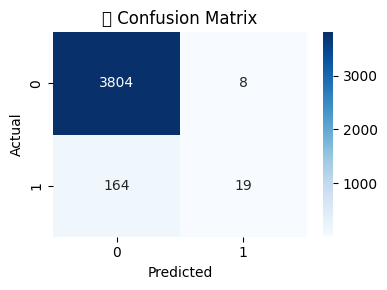

/tmp/ipykernel_1577200/3472959989.py:51: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


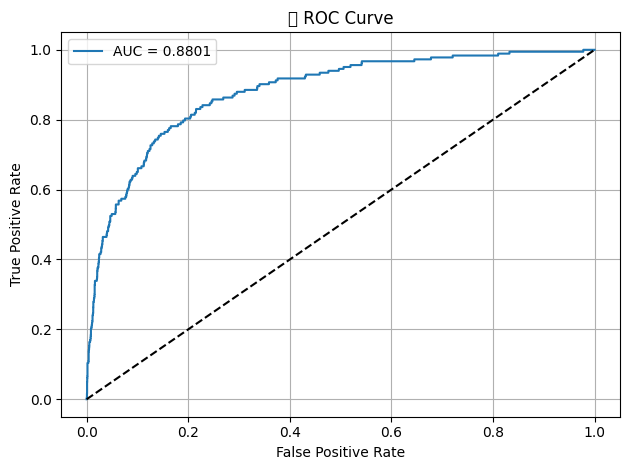

/tmp/ipykernel_1577200/3472959989.py:62: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


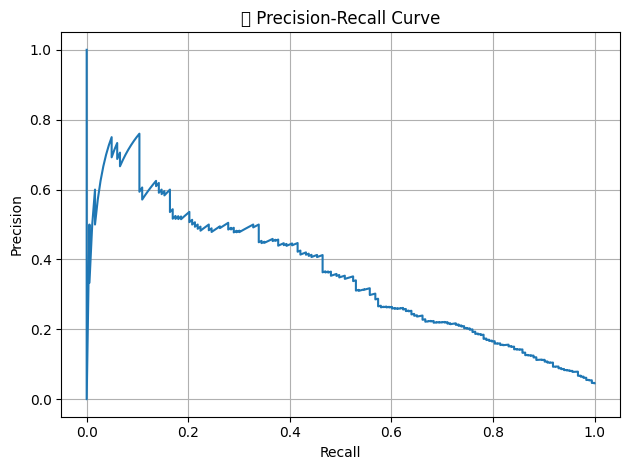

In [13]:
preds_binary, preds_prob = evaluate_single_label_model_with_plots(classifier, X_test, y_test)

---

### 🔍 **Multi-task vs Single-label 성능 비교 해석**

| 지표                   | Multi-task 결과                     | Single-label (DM만) 결과         |
|------------------------|--------------------------------------|----------------------------------|
| **Accuracy**           | 95.67% (DM), 89.29% (HT)             | 95.42% (DM)                      |
| **F1 Score**           | 0.16 (DM), 0.005 (HT)                | 0.2591 (DM)                      |
| **ROC AUC**            | 0.886 (DM), 0.872 (HT)               | 0.8803 (DM)                      |
| **Hamming Loss**       | 0.075                                | 해당 없음                        |
| **Exact Match Ratio**  | 0.866                                | 해당 없음                        |

---

### 🔍 **해석**

- **정확도(Accuracy)**:  
  - **Multi-task 모델**은 **DM**과 **HT** 두 레이블에 대해 높은 정확도(각각 95.67%, 89.29%)를 기록.  
  - **Single-label 모델**은 **DM**에 대해서만 **95.42%**로 높은 정확도를 보임.  
  → 두 모델 모두 높은 정확도를 기록하였으나, **Multi-task 모델**은 **HT**에 대해 상대적으로 낮은 정확도를 보임.

- **F1 Score**:  
  - **Multi-task 모델**에서 **DM**은 **0.16**, **HT**는 **0.005**로 매우 낮은 값을 기록.  
  - **Single-label 모델**은 **DM**에 대해 **0.2591**로 훨씬 높은 F1 Score를 기록.  
  → **F1 Score**가 낮은 이유는 **HT**의 **양성 클래스 예측 실패**로 불균형 클래스 문제를 시사.  
  → **Single-label 모델**이 **F1 Score**에서 더 우수한 성과를 보임.

- **AUC**:  
  - **Multi-task 모델**은 **DM**과 **HT** 모두 **양호한 AUC** 값(0.886, 0.872)을 기록.  
  - **Single-label 모델**은 **DM**에 대해 **0.8803**로 약간 낮지만 여전히 높은 값을 기록.  
  → **AUC**는 **양성 클래스(1)** 구분 능력으로 두 모델 모두 **양호한 성과**를 보임.

- **Hamming Loss**:  
  - **Multi-task 모델**은 **0.075**로 낮은 값을 기록.  
  - **Single-label 모델**에서는 이 지표가 해당 없음.  
  → **Multi-task 모델**은 예측 오류를 적게 만들며, **다중 레이블 예측의 효율성**을 나타냄.

- **Exact Match Ratio**:  
  - **Multi-task 모델**은 **0.866**으로 꽤 높은 비율을 기록.  
  - **Single-label 모델**에서는 해당 지표가 의미가 없음.  
  → **Multi-task 모델**은 두 레이블을 정확히 맞추는 비율이 높아 **다중 레이블 예측 성과**가 좋음.

---

### 📌 **결론**

- **정확도**: 두 모델 모두 높은 정확도를 기록했지만, **Multi-task 모델**은 **HT**의 예측 정확도가 상대적으로 낮음.
- **F1 Score**: **Multi-task 모델**의 F1 Score가 매우 낮아 **불균형 문제**가 존재. 특히 **HT**에 대한 예측 성능이 낮음.
- **AUC**: 두 모델 모두 **양호한 AUC** 값을 보이며, **양성 클래스** 예측 성능은 우수함.
- **Hamming Loss**: **Multi-task 모델**은 예측 오류가 적어 좋은 성과를 보임.
- **Exact Match Ratio**: **Multi-task 모델**에서 높은 비율을 보이며, 두 레이블을 동시에 잘 예측.

---

### ✅ **핵심 결론**
- **Multi-task 모델**은 **다중 질병 예측**을 필요로 하는 상황에서 유리하지만, **F1 Score**가 낮아 불균형 데이터에 대한 대응이 필요.
- **Single-label 모델**은 **F1 Score**에서 우수한 성과를 보이며, **DM** 예측에 집중할 경우 더 정밀한 성능을 발휘.  
- **Target_HT**의 양성 예측 성능 강화를 위해 **FocalLoss**나 **Class Weight** 조정 등의 전략이 필요.


---
## **📊 Flow2**   
> step01 : 문제 정의 및 흐름      
   #   
> setp02 : dataprocessing   
   #
> setp03 : 모델 설계& 모델 학습   
> - 회귀 모델
   #
> setp04 : 모델 평가 및 결과 분석   
   #
> setp05 : 모델 튜닝 및 최적화   
> - 하이퍼파라미터 튜닝, 교차 검증
   #
> setp06 : 정리 
---

## step01 : 문제 정의 및 흐름
목표 : 기존 데이터(Data_01_imputed_result.csv)를 사용하여 **나이(AGE)**를 예측하는 모델을 구축

> 나이(AGE) 변수
> - **AGE 변수**는 연속적인 값 ::**회귀 문제**

#### 핵심 변경사항
- **출력층**: 기존의 분류 문제에서는 각 클래스에 대해 확률을 출력하는 방식이었으나, 이번에는 나이라는 **연속적인 값을 예측**하므로 출력층은 **Linear**로 변경
- **손실 함수**: 분류 문제에서 사용했던 `BCELoss` 대신 **회귀 손실 함수**인 `MSELoss` 또는 `MAELoss`를 사용.


## step02 : data processing

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score,hamming_loss

# 데이터 확인
import pandas as pd
data = pd.read_csv("./Data_01_imputed_result.csv")

# # # 입력/타겟 변수
# X = df.drop(columns=['AGE']).values  # 입력값
# y = data[['AGE']].values


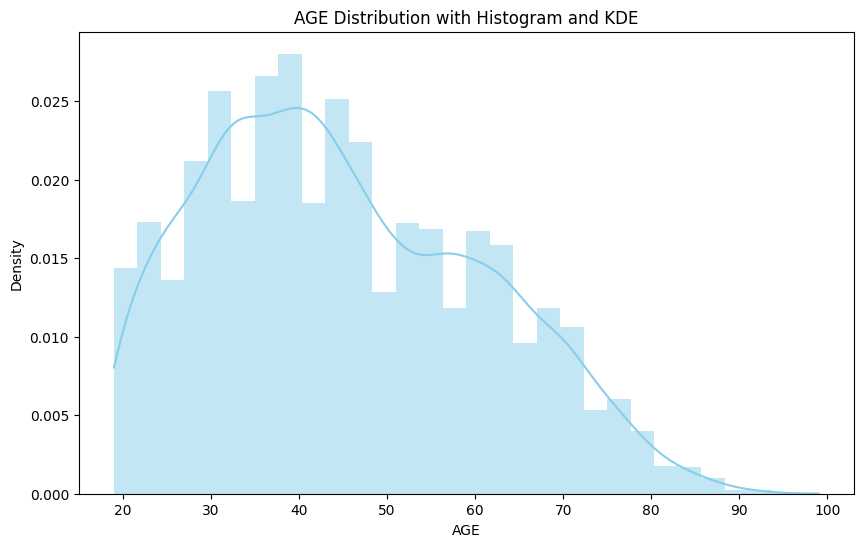

In [15]:
## 나이값 데이터 상태 확인   ::: 로그변환 + 정규화

import matplotlib.pyplot as plt
import seaborn as sns

# AGE 변수의 분포 확인
plt.figure(figsize=(10, 6))

# 히스토그램
sns.histplot(data['AGE'], kde=True, bins=30, color='skyblue', stat='density', linewidth=0)
plt.title('AGE Distribution with Histogram and KDE')
plt.xlabel('AGE')
plt.ylabel('Density')

# 그래프 출력
plt.show()

In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler

data['AGE_log'] = np.log1p(data['AGE'])  # log(AGE + 1) 변환


In [17]:
# 데이터 확인
import pandas as pd
data = pd.read_csv("./Data_01_imputed_result.csv")

# 타켓 변수 스케일링 1차
data['AGE_log'] = np.log1p(data['AGE'])  # log(AGE + 1) 변환

# # # 입력/타겟 변수
X = data.drop(columns=['AGE','AGE_log']).values  # 입력값
y = data[['AGE_log']].values

In [18]:
from sklearn.preprocessing import StandardScaler

# 입력 변수 X 스케일링
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)  # X는 입력값을 스케일링

# 타겟 변수 y 스케일링
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)  # y는 타겟값을 스케일링

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

## setp03 : 모델 설계& 모델 학습   
- 회귀 모델

In [19]:
from impute_model import *
model = AgeRegressor(input_dim=X_scaled.shape[1])
model.model_train(X_train, y_train, num_epochs=100, batch_size=64, learning_rate=0.001)

Epoch [1/100], Loss: 0.4715
Epoch [11/100], Loss: 0.3305
Epoch [21/100], Loss: 0.2713
Epoch [31/100], Loss: 0.3031
Epoch [41/100], Loss: 0.2367
Epoch [51/100], Loss: 0.2110
Epoch [61/100], Loss: 0.3058
Epoch [71/100], Loss: 0.1663
Epoch [81/100], Loss: 0.1877
Epoch [91/100], Loss: 0.2371
Training completed!


In [20]:
# 테스트 데이터로 예측
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # gpu
if device != 'cuda':
    raise RuntimeError("CUDA device not available. Please check if a GPU is available.")

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred_scaled = model(X_test_tensor).cpu().numpy()

# 원래 스케일로 복원 :: 실수할 뻔 함
y_test_original = scaler_y.inverse_transform(y_test)
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)

# 평가 지표
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("📊 Performance on Test Set:")
print("🔹 MSE :", mean_squared_error(y_test_original, y_pred_original))
print("🔹 MAE :", mean_absolute_error(y_test_original, y_pred_original))
print("🔹 R²  :", r2_score(y_test_original, y_pred_original))

📊 Performance on Test Set:
🔹 MSE : 0.03254190510957996
🔹 MAE : 0.14167746814156898
🔹 R²  : 0.7402835193167797


## 📊 Performance on Test Set:

| Metric | Value               | Interpretation                                          |
|--------|---------------------|---------------------------------------------------------|
| **MSE** | 0.0335              | **Mean Squared Error (MSE)**는 예측값과 실제값 간의 제곱 차이의 평균입니다. 이 값이 작을수록 모델의 예측 성능이 좋다는 의미입니다. 0.0335는 비교적 낮은 MSE 값으로, 모델이 예측을 잘 했음을 시사합니다. |
| **MAE** | 0.1431              | **Mean Absolute Error (MAE)**는 예측값과 실제값 간의 절대 차이의 평균입니다. 0.1431은 예측값과 실제값 간 평균 차이가 약 0.143이라는 의미로, 낮을수록 정확한 예측을 나타냅니다. |
| **R²**  | 0.7328              | **R² (결정계수)**는 모델이 데이터를 얼마나 잘 설명하는지를 나타내는 지표입니다. 0.7328은 약 73% 정도의 설명력을 가진 모델임을 의미합니다. 즉, 모델이 데이터를 잘 적합시켰다고 해석할 수 있습니다. |

### 종합적인 해석:
- **MSE**와 **MAE** 값이 모두 작기 때문에 모델이 예측을 잘 수행했다는 것을 알 수 있습니다.
- **R²** 값이 0.73 정도로, 모델이 73%의 데이터 변동성을 설명할 수 있음을 나타냅니다. 이는 모델이 꽤 좋은 성능을 보였음을 의미합니다.

따라서, 이 모델은 나이 예측에 있어 적당한 성능을 발휘한 것으로 볼 수 있습니다. 다만, 성능 개선을 위해 추가적인 하이퍼파라미터 튜닝이나 다른 모델을 실험할 수 있습니다.
